In [ ]:
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch_geometric.nn import GINConv, JumpingKnowledge
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import resize
from skimage.morphology import skeletonize, binary_dilation
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.data import Dataset  # ← voor PyG dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import cv2

# Data inladen

In [2]:
X_test_corrupt = np.load("test_inputs_aug.npy")  
X_test_corrupt_wit = np.load("test_inputs_wit.npy")
X_test_corrupt_zwart = np.load("test_inputs_zwart.npy")
y_test = np.load("y_test_targets2.npy")              
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)


# Model inladen

In [3]:
# # Laad model
# model = load_model("models/final_model_full_train.keras")
# Laad model
model = load_model(r"C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\models\final_model_full_train.keras")

# GNN functies en model inladen

In [4]:
def resize_with_padding(img, target_size=64, inner_size=60):
    """
    Resize afbeelding proportioneel zodat het in 'inner_size' past
    en vul aan met padding tot 'target_size' x 'target_size'.
    """
    h, w = img.shape
    scale = min(inner_size / h, inner_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = resize(img, (new_h, new_w), mode='constant', anti_aliasing=True)
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(resized, ((top, bottom), (left, right)), mode='constant', constant_values=0)

def preprocess_image(img, target_size=64, inner_size=60):
    """
    Preprocess een grijswaarde-afbeelding tot een skeleton:
    normalisatie, Otsu-binarisatie, crop, resize, smooth, skeletonize.
    """
    img = img / 255.0 if img.max() > 1 else img
    threshold = threshold_otsu(img)
    binary = img > threshold

    rows, cols = np.any(binary, axis=1), np.any(binary, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    margin = 1
    rmin = max(rmin - margin, 0)
    rmax = min(rmax + margin, img.shape[0] - 1)
    cmin = max(cmin - margin, 0)
    cmax = min(cmax + margin, img.shape[1] - 1)
    cropped = img[rmin:rmax+1, cmin:cmax+1]

    resized = resize_with_padding(cropped, target_size, inner_size)
    smoothed = gaussian(resized, sigma=1.0)
    binary = smoothed > threshold_otsu(smoothed)

    skeleton1 = skeletonize(binary)
    dilated = binary_dilation(skeleton1)
    skeleton = skeletonize(dilated)
    return skeleton

def skeleton_to_graph(skeleton):
    """
    Zet een skeleton afbeelding om naar een graf waarbij pixels knopen zijn
    en randen tussen naburige skeletpunten worden gelegd.
    """
    coords = np.argwhere(skeleton)
    G = nx.Graph()
    for y, x in coords:
        G.add_node((x, y))
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < skeleton.shape[0] and 0 <= nx_ < skeleton.shape[1]:
                    if skeleton[ny, nx_]:
                        G.add_edge((x, y), (nx_, ny))
    return G

def project_graph_to_grid(G, grid_size=8, image_size=64):
    """
    Projecteer een graf op een raster van formaat grid_size x grid_size.
    Elke knoop wordt gemapt naar een cel en randen tussen cellen worden toegevoegd.
    """
    cell_size = image_size // grid_size
    G_projected = nx.Graph()
    point_to_cell = {}
    added_edges = set()

    for x, y in G.nodes:
        cx = int(x / cell_size)
        cy = int(y / cell_size)
        cell = (cx, cy)
        point_to_cell[(x, y)] = cell
        G_projected.add_node(cell)

    for u, v in G.edges:
        cu = point_to_cell.get(u)
        cv = point_to_cell.get(v)
        if cu and cv and cu != cv:
            edge = tuple(sorted((cu, cv)))
            if edge not in added_edges:
                G_projected.add_edge(*edge)
                added_edges.add(edge)

    return G_projected


def graph_to_pyg_data(G, grid_size=8, label=None):
    """
    Zet een graf om naar een PyTorch Geometric 'Data' object
    met one-hot node features, bidirectionele randen en optioneel een label.
    """
    num_nodes = grid_size * grid_size
    node_index_map = { (x, y): y * grid_size + x for x in range(grid_size) for y in range(grid_size) }

    features = []
    for y in range(grid_size):
         for x in range(grid_size):
            idx = y * grid_size + x
            one_hot = torch.zeros(num_nodes)
            one_hot[idx] = 1.0
            features.append(one_hot)

    x = torch.stack(features) 

    edge_index = []
    for (u, v) in G.edges:
        uid = node_index_map.get(u)
        vid = node_index_map.get(v)
        if uid is not None and vid is not None:
            edge_index.append([uid, vid])
            edge_index.append([vid, uid])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)

    if label is not None:
        data.y = torch.tensor([label], dtype=torch.long)

    return data


In [5]:
from torch.utils.data import Dataset

In [6]:

class PyGSkeletonDataset(Dataset):
    """
    Dataset-klasse die afbeeldingen omzet in geskeletoniseerde grafen,
    geprojecteerd op een rooster, klaar voor gebruik in PyTorch Geometric.
    """
    def __init__(self, images, labels=None, grid_size=8):
        """
        Initialiseert de dataset door elke afbeelding om te zetten in een PyG graf.
        
        Args:
            images (list or array): Lijst van grijswaarde-afbeeldingen.
            labels (list or array, optional): Optionele labels per afbeelding.
            grid_size (int): Grootte van het raster (bijv. 8 voor 8x8).
        """
        self.images = images
        self.labels = labels
        self.grid_size = grid_size
        self.graphs = [self._image_to_graph(img, i) for i, img in enumerate(images)]

    def _image_to_graph(self, img, idx):
        """
        Zet één afbeelding om naar een geskeletoniseerde, gerasterde graf.
        
        Args:
            img (np.ndarray): Grijswaarde-afbeelding.
            idx (int): Index van de afbeelding, gebruikt om het juiste label te vinden.
        
        Returns:
            torch_geometric.data.Data: Graph-representatie van de afbeelding.
        """
        skeleton = preprocess_image(img)
        G = skeleton_to_graph(skeleton)
        G_proj = project_graph_to_grid(G, grid_size=self.grid_size)
        label = self.labels[idx] if self.labels is not None else None
        return graph_to_pyg_data(G_proj, grid_size=self.grid_size, label=label)

    def __len__(self):
        """
        Geeft het aantal grafen in de dataset.
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Haalt één PyG graf op uit de dataset.
        
        Args:
            idx (int): Index van het gewenste datapunt.
        
        Returns:
            torch_geometric.data.Data: De graf op positie idx.
        """
        return self.graphs[idx]

In [7]:
def edge_index_to_image(edge_index, image_size=64, grid_size=8, line_thickness=3):
    """
    Zet een edge_index om naar een binair beeld (float32, 0-1) door lijnen te tekenen
    tussen de knopen van een 8x8 grid. Output is shape (64, 64) in float.
    """
    # Leeg canvas
    img = np.zeros((image_size, image_size), dtype=np.uint8)

    # Celgrootte en coördinaten berekenen
    cell_size = image_size // grid_size
    positions = {
        i: (int((i % grid_size + 0.5) * cell_size),
            int((i // grid_size + 0.5) * cell_size))
        for i in range(grid_size * grid_size)
    }

    # Lijnen tekenen
    for u, v in edge_index.t().tolist():
        pt1 = positions[u]
        pt2 = positions[v]
        cv2.line(img, pt1, pt2, color=255, thickness=line_thickness)

    # Schalen naar float32 in [0, 1]
    img = img.astype(np.float32) / 255.0

    return img


In [8]:
def reconstruct_edges(data, model, threshold=0.98):
    """
    Reconstrueert een edge index uit modelvoorspellingen.
    Bepaalt voor elk knopenpaar of er een rand bestaat op basis van drempel op predicties.
    """
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)

    # Genereer alle mogelijke nodeparen in grid
    num_nodes = data.num_nodes
    row, col = torch.meshgrid(torch.arange(num_nodes), torch.arange(num_nodes), indexing='ij')
    full_edge_index = torch.stack([row.flatten(), col.flatten()], dim=0).to(device)

    # Decode scores (edge probabilities)
    scores = model.decode(z, full_edge_index).sigmoid()

    # Houd alleen edges boven drempel
    keep = scores > threshold
    edge_index_reconstructed = full_edge_index[:, keep]

    return edge_index_reconstructed.cpu()

def zijn_directe_buren(u, v):
    """Controleer of twee knopen directe buren zijn op een 8x8 raster, inclusief diagonalen."""
    x1, y1 = u % 8, u // 8
    x2, y2 = v % 8, v // 8
    return max(abs(x1 - x2), abs(y1 - y2)) == 1 and (u != v)

def filter_directe_buren(edge_index):
    """Behoud alleen edges tussen directe buren."""
    filtered_edges = []
    for u, v in edge_index.t().tolist():
        if zijn_directe_buren(u, v):
            filtered_edges.append((u, v))
    return torch.tensor(filtered_edges).t()

from torch_geometric.utils import remove_self_loops
import matplotlib.pyplot as plt

def show_corrupt_vs_reconstruction(corrupted_data, reconstructed_edge_index, drop_rate=0.0):
    """
    Toont corrupte en gereconstrueerde graaf in één figuur.
    Verwijdert self-loops, behoudt alleen directe buren, en toont het label van de graaf.
    
    Args:
        corrupted_data: PyG Data object met de corrupte graaf.
        reconstructed_edge_index: edge_index van de gereconstrueerde graaf.
        drop_rate: toegepaste corruptie (float tussen 0 en 1).
    """
    # Verwijder self-loops
    reconstructed_edges, _ = remove_self_loops(reconstructed_edge_index)

    # Behoud alleen directe buren
    reconstructed_edges = filter_directe_buren(reconstructed_edges)

    # Haal label op
    label = corrupted_data.y.item() if hasattr(corrupted_data, 'y') else "?"

    # Maak figuur
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    titel_corrupt = f"Kapotte graaf\n(corruptie: {drop_rate:.2f})"
    titel_recon = "Gereconstrueerde graaf"

    plot_graph(axes[0], corrupted_data.edge_index, titel_corrupt, color='blue')
    plot_graph(axes[1], reconstructed_edges, titel_recon, color='green')

    # Toon label bovenaan de hele figuur
    fig.suptitle(f"Label: {label}", fontsize=16)

    plt.tight_layout()
    plt.show()


    
def plot_graph(ax, edge_index, title, color='b'):
    """
    Plot een graf met knopen in een 8x8 raster op een gegeven subplot-as (ax).
    Maakt gebruik van NetworkX en tekent knopen, randen.
    """
    G = nx.Graph()
    positions = {i: (i % 8, 7 - i // 8) for i in range(64)}  

    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    G.add_nodes_from(range(64))  

    nx.draw(
        G,
        pos=positions,
        node_size=100,
        edge_color=color,
        node_color='gray',
        with_labels=False,
        ax=ax  
    )

    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(-0.5, 7.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off') 



In [9]:
# --- GIN Encoder met Jumping Knowledge over 3 lagen ---
class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()
        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

# --- MLP Decoder ---
class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, 1)
        )

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        z_pair = torch.cat([z_i, z_j], dim=1)
        return self.mlp(z_pair).squeeze()

# --- VGAE met MLP decoder ---
class VGAE_MLP(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([
            torch.ones_like(pos_out),
            torch.zeros_like(neg_out)
        ])
        
        # Correct gebruik van scalar pos_weight
        pos_weight = len(neg_out) / len(pos_out)
        pos_weight = torch.tensor(pos_weight, device=z.device)

        return F.binary_cross_entropy_with_logits(preds, labels, pos_weight=pos_weight)



    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = MLPDecoder(latent_dim=32)
model_gnn = VGAE_MLP(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.001)



In [10]:
model_gnn = torch.load("VGAE_final.pt", map_location=device, weights_only=False)
model_gnn.eval()

VGAE_MLP(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1,

# Zwart

## INITIËLE CNN-VOORSPELLING OP CORRUPTE TESTSET 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Accuracy op corrupte testset (zwart): 0.9286
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
           1     1.0000    0.9474    0.9730        19
           2     0.9048    0.9500    0.9268        20
           3     0.7333    1.0000    0.8462        11
           4     1.0000    0.7826    0.8780        23
           5     0.9375    0.9375    0.9375        16
           6     0.8571    1.0000    0.9231        12
           7     0.9333    0.8235    0.8750        17
           8     0.9091    1.0000    0.9524        20
           9     1.0000    0.9286    0.9630        14

    accuracy                         0.9286       168
   macro avg     0.9275    0.9370    0.9275       168
weighted avg     0.9375    0.9286    0.9286       168



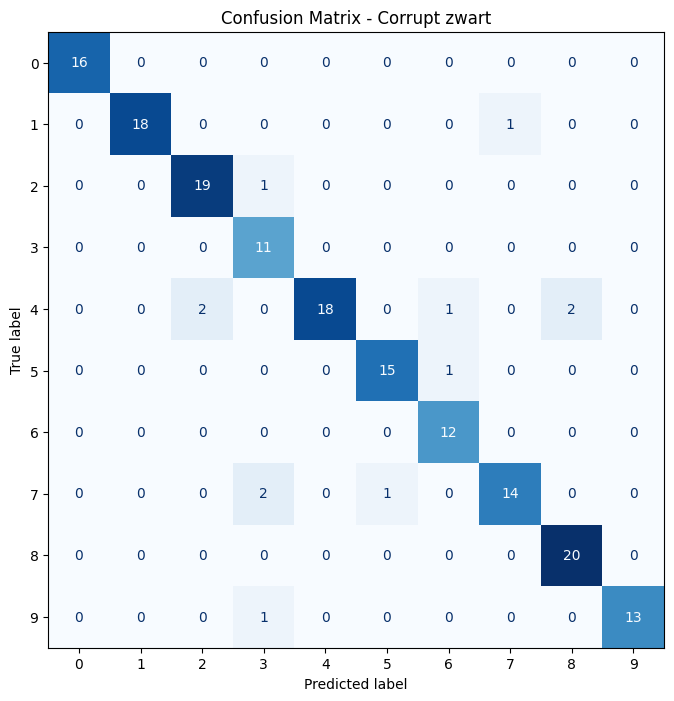

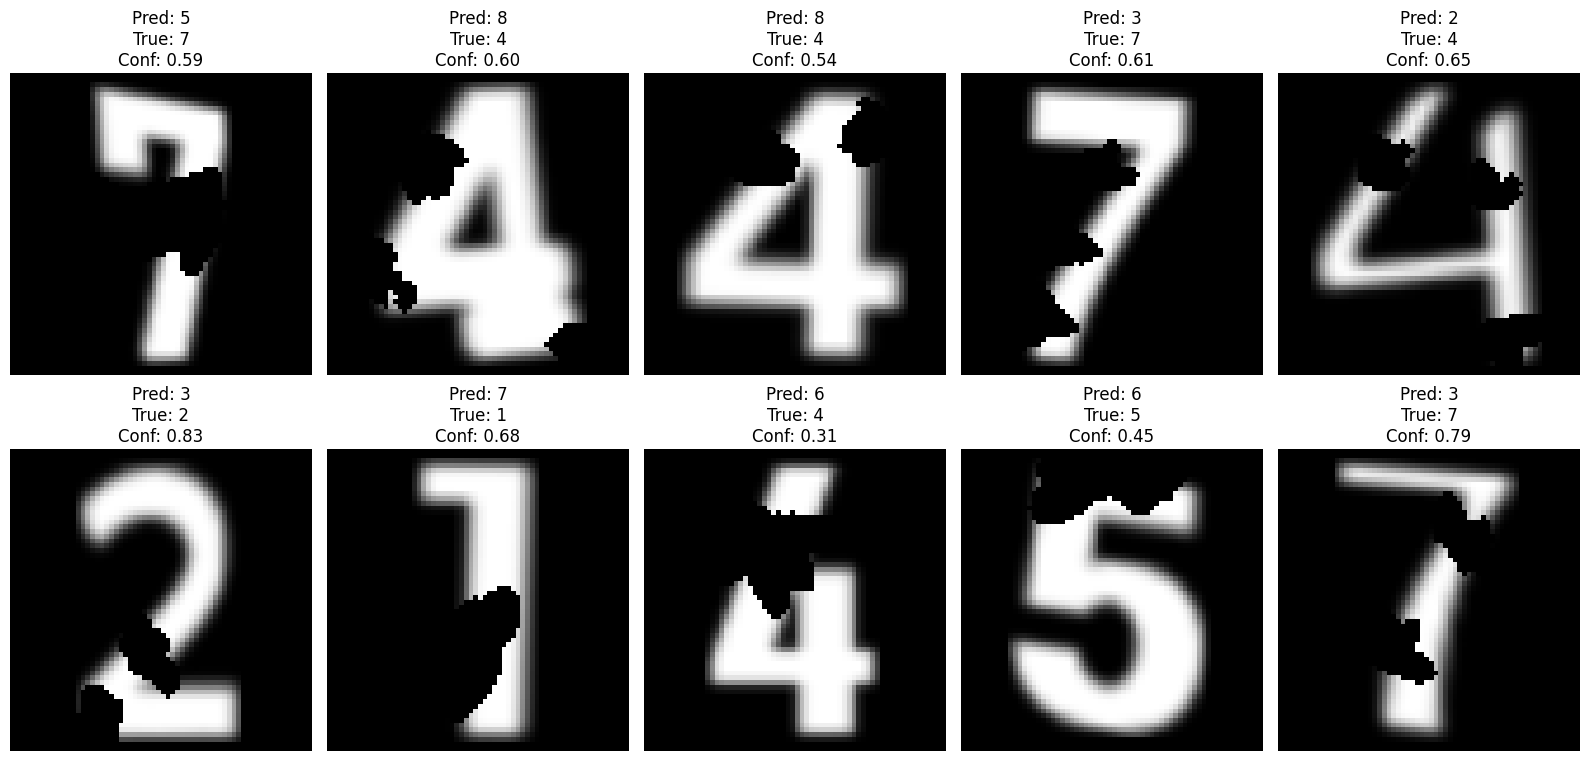

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- [1] INITIËLE CNN-VOORSPELLING OP CORRUPTE TESTSET (zwart) ---
y_pred_probs_zwart = model.predict(X_test_corrupt_zwart)
y_pred_zwart = np.argmax(y_pred_probs_zwart, axis=1)

# Evaluatie
acc_zwart = accuracy_score(y_test, y_pred_zwart)
print(f"Accuracy op corrupte testset (zwart): {acc_zwart:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_zwart, digits=4))

# Confusion Matrix
cm_zwart = confusion_matrix(y_test, y_pred_zwart)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_zwart, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Corrupt zwart")
plt.show()

# Toon enkele foutieve voorbeelden
wrong_indices = np.where(y_pred_zwart != y_test)[0]
plt.figure(figsize=(16, 8))
for i, idx in enumerate(wrong_indices[:10]):
    img = X_test_corrupt_zwart[idx].squeeze()
    pred = y_pred_zwart[idx]
    true = y_test[idx]
    conf = np.max(y_pred_probs_zwart[idx])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred}\nTrue: {true}\nConf: {conf:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## CONFIDENCE-ANALYSE

In [12]:
conf_zwart = np.max(y_pred_probs_zwart, axis=1)
conf_thresh = 0.8

# Maskers
high_mask_zwart = conf_zwart >= conf_thresh
low_mask_zwart = conf_zwart < conf_thresh

# Statistieken
n_total = len(y_test)
n_high = np.sum(high_mask_zwart)
n_low = np.sum(low_mask_zwart)
correct_high = np.sum(y_pred_zwart[high_mask_zwart] == y_test[high_mask_zwart])
correct_low = np.sum(y_pred_zwart[low_mask_zwart] == y_test[low_mask_zwart])

print(f"\nConfidence verdeling (drempel {conf_thresh}):")
print(f"  Hoog vertrouwen: {n_high}/{n_total} ({n_high/n_total:.2%})")
print(f"    → Goed: {correct_high}   Fout: {n_high - correct_high}")
print(f"  Laag vertrouwen: {n_low}/{n_total} ({n_low/n_total:.2%})")
print(f"    → Goed: {correct_low}   Fout: {n_low - correct_low}")



Confidence verdeling (drempel 0.8):
  Hoog vertrouwen: 139/168 (82.74%)
    → Goed: 138   Fout: 1
  Laag vertrouwen: 29/168 (17.26%)
    → Goed: 18   Fout: 11


## GNN-RECONSTRUCTIE VAN LAGE-CONFIDENCE BEELDEN

In [13]:
X_lowconf_zwart = X_test_corrupt_zwart[low_mask_zwart]
y_lowconf_zwart = y_test[low_mask_zwart]

In [14]:
# [4] Maak dataset van lage confidence voorbeelden
lowconf_dataset_zwart = PyGSkeletonDataset(images=X_lowconf_zwart.squeeze(), labels=y_lowconf_zwart, grid_size=8)

# [5] Reconstructeer
reconstructed_images_zwart = []
for data in lowconf_dataset_zwart:
    reconstructed_edge_index = reconstruct_edges(data, model_gnn, threshold=0.98)
    reconstructed_edge_index, _ = remove_self_loops(reconstructed_edge_index)
    reconstructed_edge_index = filter_directe_buren(reconstructed_edge_index)
    binary_img = edge_index_to_image(reconstructed_edge_index)
    reconstructed_images_zwart.append(binary_img)

reconstructed_images_zwart = np.expand_dims(np.array(reconstructed_images_zwart), axis=-1).astype(np.float32)


In [15]:
# [6] Maak kopie van originele corrupte dataset
X_test_fixed_zwart = X_test_corrupt_zwart.copy()

# [7] Vind de exacte indexen die vervangen moeten worden
lowconf_indices = np.where(low_mask_zwart)[0]

# [8] Controleer of alles klopt qua grootte
assert len(lowconf_indices) == len(reconstructed_images_zwart), "Mismatch in reconstructie-aantallen"

# [9] Vervang exact op de juiste plek
for i, idx in enumerate(lowconf_indices):
    X_test_fixed_zwart[idx] = reconstructed_images_zwart[i]


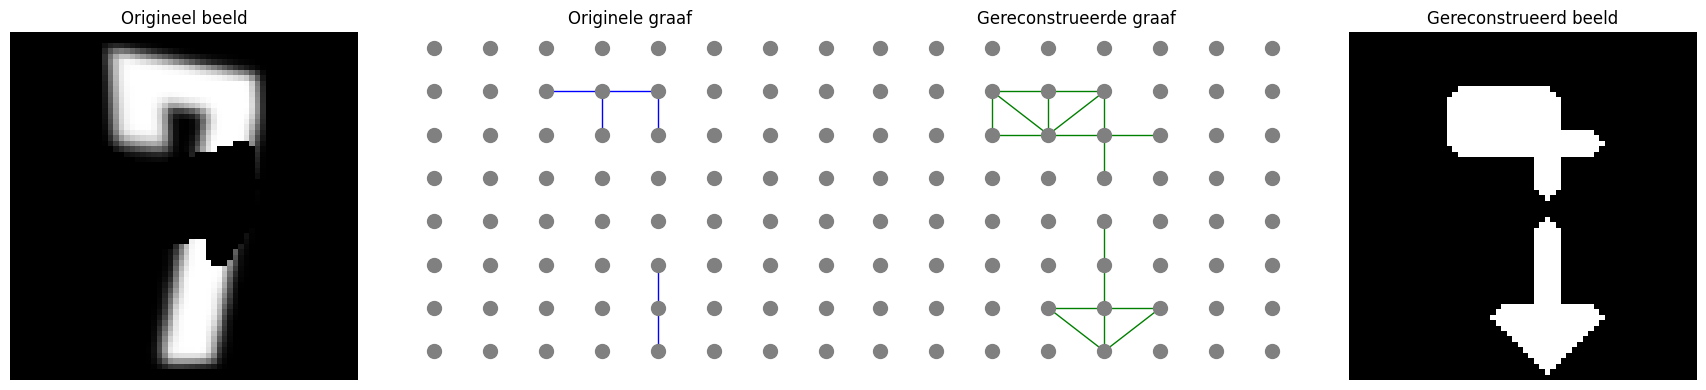

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

# Selecteer een voorbeeld uit low confidence dataset
sample_data = lowconf_dataset_zwart[0]
original_img = X_lowconf_zwart[0].squeeze()

# Reconstrueer graaf
reconstructed_edge_index = reconstruct_edges(sample_data, model_gnn, threshold=0.96)
reconstructed_edge_index, _ = remove_self_loops(reconstructed_edge_index)
reconstructed_edge_index = filter_directe_buren(reconstructed_edge_index)
binary_img = edge_index_to_image(reconstructed_edge_index)

# Posities van 8x8 grid
positions = {i: (i % 8, 7 - i // 8) for i in range(64)}

# Functie om edge_index naar networkx-graf om te zetten
def edge_index_to_nx(edge_index):
    G = nx.Graph()
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    G.add_nodes_from(range(64))
    return G

# Originele en gereconstrueerde graaf
original_graph = edge_index_to_nx(sample_data.edge_index)
reconstructed_graph = edge_index_to_nx(reconstructed_edge_index)

# Visualisatie
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# 1. Origineel beeld
axes[0].imshow(original_img, cmap='gray')
axes[0].set_title("Origineel beeld")
axes[0].axis('off')

# 2. Originele graaf
nx.draw(original_graph, pos=positions, node_size=100, node_color='gray',
        edge_color='blue', with_labels=False, ax=axes[1])
axes[1].set_title("Originele graaf")

# 3. Gereconstrueerde graaf
nx.draw(reconstructed_graph, pos=positions, node_size=100, node_color='gray',
        edge_color='green', with_labels=False, ax=axes[2])
axes[2].set_title("Gereconstrueerde graaf")

# 4. Beeld uit gereconstrueerde graaflow_conf_mask
axes[3].imshow(binary_img, cmap='gray')
axes[3].set_title("Gereconstrueerd beeld")
axes[3].axis('off')

plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Resultaten na reconstructie (zwart) met confidence check:
Accuracy: 0.9405
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
           1     0.9444    0.8947    0.9189        19
           2     0.9048    0.9500    0.9268        20
           3     0.8462    1.0000    0.9167        11
           4     1.0000    0.8261    0.9048        23
           5     1.0000    1.0000    1.0000        16
           6     0.9167    0.9167    0.9167        12
           7     1.0000    0.8824    0.9375        17
           8     0.9091    1.0000    0.9524        20
           9     0.8750    1.0000    0.9333        14

    accuracy                         0.9405       168
   macro avg     0.9396    0.9470    0.9407       168
weighted avg     0.9451    0.9405    0.9401       168



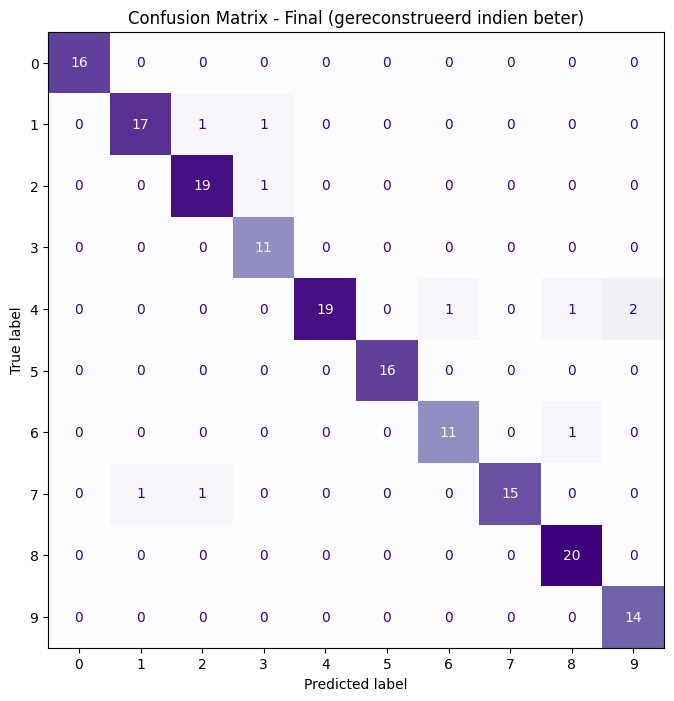


Aantal verbeterd (fout → goed): 4
Aantal verslechterd (goed → fout): 2


In [ ]:
if X_test_fixed_zwart.max() > 1:
    X_test_fixed_zwart = X_test_fixed_zwart / 255.0

y_pred_probs_orig = model.predict(X_test_corrupt_zwart)
y_pred_orig = np.argmax(y_pred_probs_orig, axis=1)
conf_orig = np.max(y_pred_probs_orig, axis=1)

y_pred_probs_fixed = model.predict(X_test_fixed_zwart)
y_pred_fixed = np.argmax(y_pred_probs_fixed, axis=1)
conf_fixed = np.max(y_pred_probs_fixed, axis=1)

y_pred_final = y_pred_orig.copy()
use_recon_mask = conf_fixed > conf_orig
y_pred_final[use_recon_mask] = y_pred_fixed[use_recon_mask]



print("\nResultaten na reconstructie (zwart) met confidence check:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_final, digits=4))

# Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Purples', colorbar=False)
plt.title("Confusion Matrix - Final (gereconstrueerd indien beter)")
plt.show()
# PLAK DIT BLOK HIERNA:
reconstructed_indices = np.where(conf_fixed > conf_orig)[0]

original_preds = y_pred_orig[reconstructed_indices]
reconstructed_preds = y_pred_fixed[reconstructed_indices]
true_labels = y_test[reconstructed_indices]

verbeterd = np.sum((original_preds != true_labels) & (reconstructed_preds == true_labels))
verslechterd = np.sum((original_preds == true_labels) & (reconstructed_preds != true_labels))

print(f"\nAantal verbeterd (fout → goed): {verbeterd}")
print(f"Aantal verslechterd (goed → fout): {verslechterd}")



Accuracy per cijfer (voor en na reconstructie):
       Accuracy (Origineel)  Accuracy (Na Reconstructie)
label                                                   
0                    1.0000                       1.0000
1                    0.9474                       0.8947
2                    0.9500                       0.9500
3                    1.0000                       1.0000
4                    0.7826                       0.8261
5                    0.9375                       1.0000
6                    1.0000                       0.9167
7                    0.8235                       0.8824
8                    1.0000                       1.0000
9                    0.9286                       1.0000


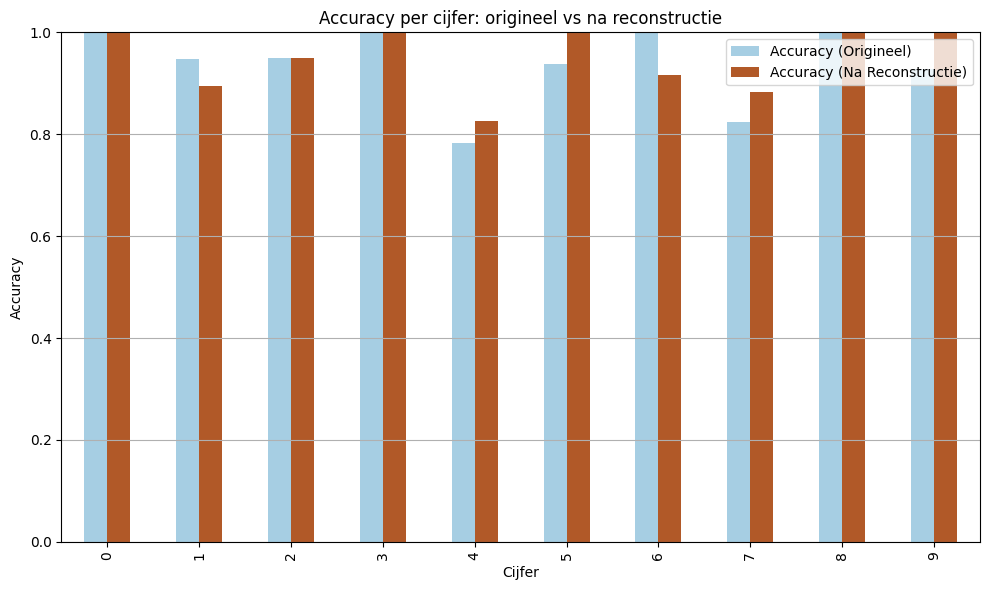


Gemiddelde cijfer-accuratesse vóór reconstructie: 0.9286
Gemiddelde cijfer-accuratesse ná reconstructie:  0.9405


In [ ]:
import pandas as pd

# Per-klas accuracy vóór reconstructie
acc_per_class_orig = (y_pred_orig == y_test)
acc_orig_df = pd.DataFrame({'label': y_test, 'correct': acc_per_class_orig})
acc_per_digit_orig = acc_orig_df.groupby('label')['correct'].mean()

# Per-klas accuracy ná reconstructie (met confidence check)
acc_per_class_final = (y_pred_final == y_test)
acc_final_df = pd.DataFrame({'label': y_test, 'correct': acc_per_class_final})
acc_per_digit_final = acc_final_df.groupby('label')['correct'].mean()

# Combineer
acc_comparison = pd.DataFrame({
    'Accuracy (Origineel)': acc_per_digit_orig,
    'Accuracy (Na Reconstructie)': acc_per_digit_final
}).round(4)

print("\nAccuracy per cijfer (voor en na reconstructie):")
print(acc_comparison)
acc_comparison.plot(kind='bar', figsize=(10, 6), colormap='Paired')
plt.title("Accuracy per cijfer: origineel vs na reconstructie")
plt.xlabel("Cijfer")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Gemiddelde cijfer-accuratesse vóór reconstructie
cijfer_acc_orig = accuracy_score(y_test, y_pred_orig)

# Gemiddelde cijfer-accuratesse ná reconstructie (met confidence check)
cijfer_acc_final = accuracy_score(y_test, y_pred_final)

print(f"\nGemiddelde cijfer-accuratesse vóór reconstructie: {cijfer_acc_orig:.4f}")
print(f"Gemiddelde cijfer-accuratesse ná reconstructie:  {cijfer_acc_final:.4f}")


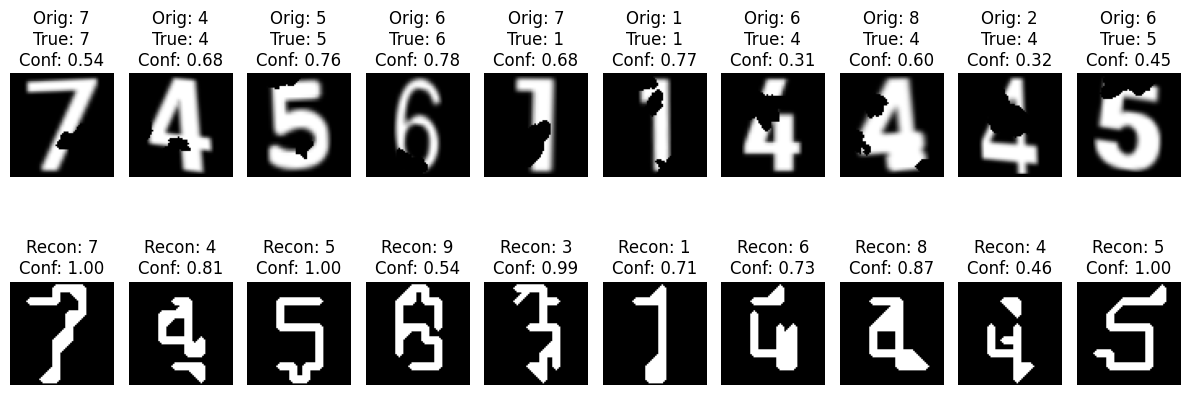

In [19]:
n = 10
np.random.seed(40)
indices = np.random.choice(lowconf_indices, size=n, replace=False)

plt.figure(figsize=(12, 5))
for i, original_idx in enumerate(indices):
    # Positie in gerepareerde set
    fixed_idx = original_idx

    # Origineel (voor reconstructie)
    plt.subplot(2, n, i + 1)
    orig_img = X_test_corrupt_zwart[original_idx].squeeze()
    orig_conf = conf_zwart[original_idx]
    orig_pred = y_pred_zwart[original_idx]
    true_label = y_test[original_idx]
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Orig: {orig_pred}\nTrue: {true_label}\nConf: {orig_conf:.2f}")
    plt.axis('off')

    # Gereconstrueerd beeld dat op dezelfde plek zit in de gerepareerde set
    plt.subplot(2, n, i + 1 + n)
    recon_img = X_test_fixed_zwart[fixed_idx].squeeze()
    recon_pred = y_pred_fixed[fixed_idx]
    recon_conf = np.max(y_pred_probs_fixed[fixed_idx])
    plt.imshow(recon_img, cmap='gray')
    plt.title(f"Recon: {recon_pred}\nConf: {recon_conf:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Wit

## INITIËLE CNN-VOORSPELLING OP CORRUPTE TESTSET 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy op corrupte testset (wit): 0.7619
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
           1     0.9000    0.4737    0.6207        19
           2     0.7200    0.9000    0.8000        20
           3     0.8182    0.8182    0.8182        11
           4     1.0000    0.6522    0.7895        23
           5     1.0000    0.6875    0.8148        16
           6     0.6250    0.8333    0.7143        12
           7     0.5714    0.4706    0.5161        17
           8     0.6452    1.0000    0.7843        20
           9     0.6316    0.8571    0.7273        14

    accuracy                         0.7619       168
   macro avg     0.7911    0.7693    0.7585       168
weighted avg     0.8004    0.7619    0.7572       168



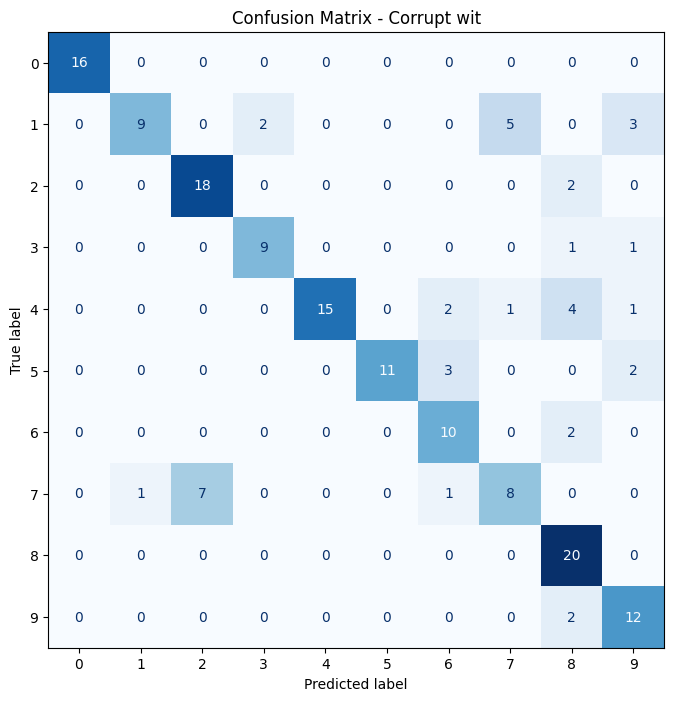

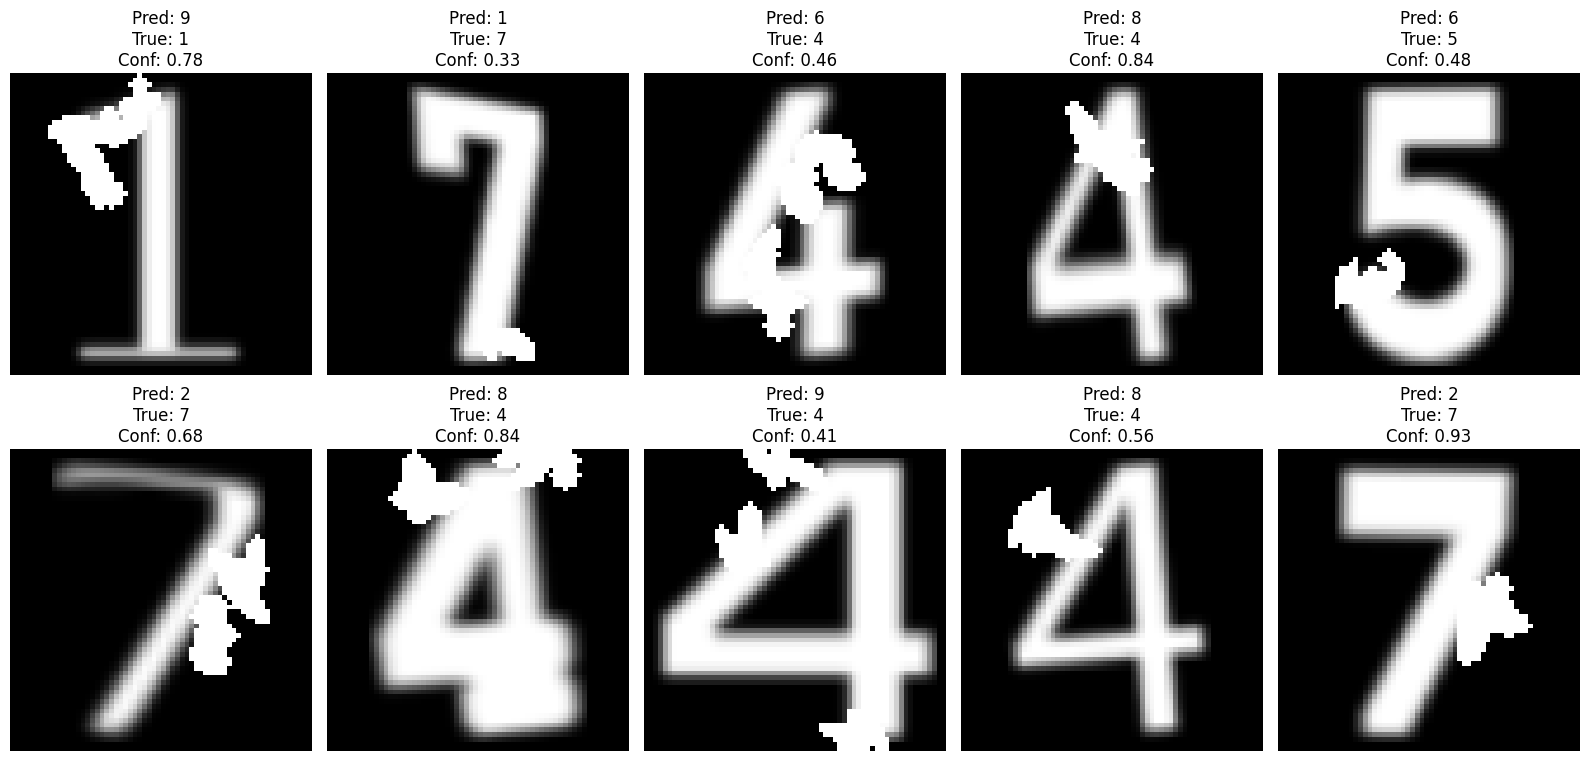

In [ ]:
y_pred_probs_wit = model.predict(X_test_corrupt_wit)
y_pred_wit = np.argmax(y_pred_probs_wit, axis=1)

# Evaluatie
acc_wit = accuracy_score(y_test, y_pred_wit)
print(f"Accuracy op corrupte testset (wit): {acc_wit:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_wit, digits=4))

# Confusion Matrix
cm_wit = confusion_matrix(y_test, y_pred_wit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_wit, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Corrupt wit")
plt.show()

# Toon enkele foutieve voorbeelden
wrong_indices = np.where(y_pred_wit != y_test)[0]
plt.figure(figsize=(16, 8))
for i, idx in enumerate(wrong_indices[:10]):
    img = X_test_corrupt_wit[idx].squeeze()
    pred = y_pred_wit[idx]
    true = y_test[idx]
    conf = np.max(y_pred_probs_wit[idx])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred}\nTrue: {true}\nConf: {conf:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## CONFIDENCE-ANALYSE

In [21]:
conf_wit = np.max(y_pred_probs_wit, axis=1)
conf_thresh = 0.8

# Maskers
high_mask_wit = conf_wit >= conf_thresh
low_mask_wit = conf_wit < conf_thresh

# Statistieken
n_total = len(y_test)
n_high = np.sum(high_mask_wit)
n_low = np.sum(low_mask_wit)
correct_high = np.sum(y_pred_wit[high_mask_wit] == y_test[high_mask_wit])
correct_low = np.sum(y_pred_wit[low_mask_wit] == y_test[low_mask_wit])

print(f"\nConfidence verdeling (drempel {conf_thresh}):")
print(f"  Hoog vertrouwen: {n_high}/{n_total} ({n_high/n_total:.2%})")
print(f"    → Goed: {correct_high}   Fout: {n_high - correct_high}")
print(f"  Laag vertrouwen: {n_low}/{n_total} ({n_low/n_total:.2%})")
print(f"    → Goed: {correct_low}   Fout: {n_low - correct_low}")



Confidence verdeling (drempel 0.8):
  Hoog vertrouwen: 126/168 (75.00%)
    → Goed: 109   Fout: 17
  Laag vertrouwen: 42/168 (25.00%)
    → Goed: 19   Fout: 23


## GNN-RECONSTRUCTIE VAN LAGE-CONFIDENCE BEELDEN

In [22]:
X_lowconf_wit = X_test_corrupt_wit[low_mask_wit]
y_lowconf_wit = y_test[low_mask_wit]

In [ ]:
lowconf_dataset_wit = PyGSkeletonDataset(images=X_lowconf_wit.squeeze(), labels=y_lowconf_wit, grid_size=8)

reconstructed_images_wit = []
for data in lowconf_dataset_wit:
    reconstructed_edge_index = reconstruct_edges(data, model_gnn, threshold=0.98)
    reconstructed_edge_index, _ = remove_self_loops(reconstructed_edge_index)
    reconstructed_edge_index = filter_directe_buren(reconstructed_edge_index)
    binary_img = edge_index_to_image(reconstructed_edge_index)
    reconstructed_images_wit.append(binary_img)

reconstructed_images_wit = np.expand_dims(np.array(reconstructed_images_wit), axis=-1).astype(np.float32)


In [ ]:
X_test_fixed_wit = X_test_corrupt_wit.copy()

lowconf_indices = np.where(low_mask_wit)[0]

assert len(lowconf_indices) == len(reconstructed_images_wit), "Mismatch in reconstructie-aantallen"

for i, idx in enumerate(lowconf_indices):
    X_test_fixed_wit[idx] = reconstructed_images_wit[i]


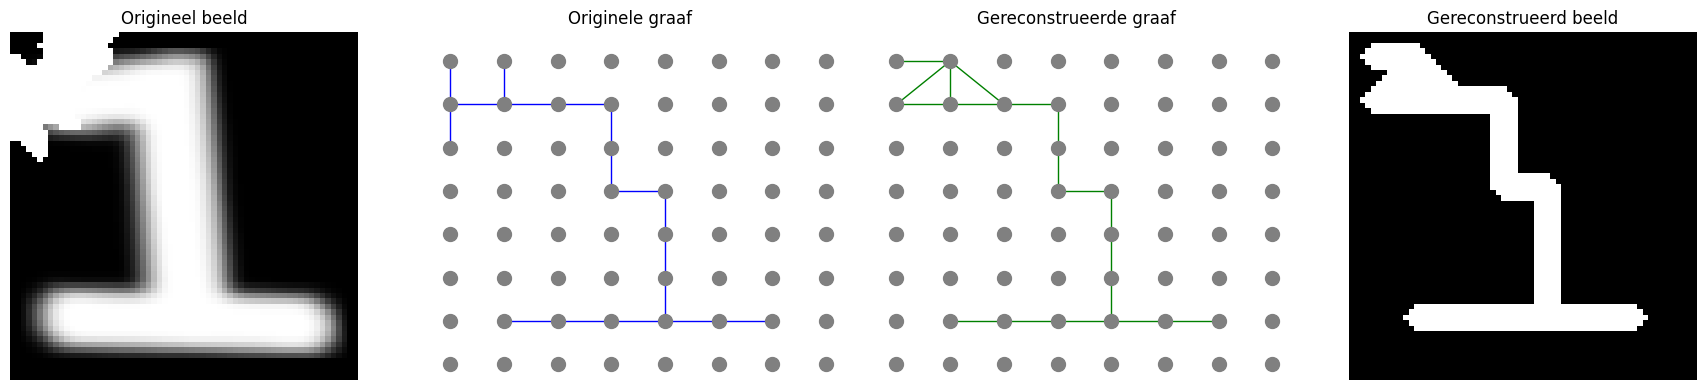

In [ ]:
sample_data = lowconf_dataset_wit[0]
original_img = X_lowconf_wit[0].squeeze()

# Reconstrueer graaf
reconstructed_edge_index = reconstruct_edges(sample_data, model_gnn, threshold=0.96)
reconstructed_edge_index, _ = remove_self_loops(reconstructed_edge_index)
reconstructed_edge_index = filter_directe_buren(reconstructed_edge_index)
binary_img = edge_index_to_image(reconstructed_edge_index)

# Posities van 8x8 grid
positions = {i: (i % 8, 7 - i // 8) for i in range(64)}

# Functie om edge_index naar networkx-graf om te zetten
def edge_index_to_nx(edge_index):
    G = nx.Graph()
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    G.add_nodes_from(range(64))
    return G

# Originele en gereconstrueerde graaf
original_graph = edge_index_to_nx(sample_data.edge_index)
reconstructed_graph = edge_index_to_nx(reconstructed_edge_index)

# Visualisatie
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# 1. Origineel beeld
axes[0].imshow(original_img, cmap='gray')
axes[0].set_title("Origineel beeld")
axes[0].axis('off')

# 2. Originele graaf
nx.draw(original_graph, pos=positions, node_size=100, node_color='gray',
        edge_color='blue', with_labels=False, ax=axes[1])
axes[1].set_title("Originele graaf")

# 3. Gereconstrueerde graaf
nx.draw(reconstructed_graph, pos=positions, node_size=100, node_color='gray',
        edge_color='green', with_labels=False, ax=axes[2])
axes[2].set_title("Gereconstrueerde graaf")

# 4. Beeld uit gereconstrueerde graaflow_conf_mask
axes[3].imshow(binary_img, cmap='gray')
axes[3].set_title("Gereconstrueerd beeld")
axes[3].axis('off')

plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

✅ Resultaten na reconstructie (wit) met confidence check:
Accuracy: 0.7857
Classification Report:
              precision    recall  f1-score   support

           0     0.9412    1.0000    0.9697        16
           1     0.8333    0.5263    0.6452        19
           2     0.7200    0.9000    0.8000        20
           3     0.7500    0.8182    0.7826        11
           4     1.0000    0.6522    0.7895        23
           5     1.0000    0.7500    0.8571        16
           6     0.7857    0.9167    0.8462        12
           7     0.6923    0.5294    0.6000        17
           8     0.7917    0.9500    0.8636        20
           9     0.5417    0.9286    0.6842        14

    accuracy                         0.7857       168
   macro avg     0.8056    0.7971    0.7838       168
weighted avg     0.8164    0.7857    0.7825       168



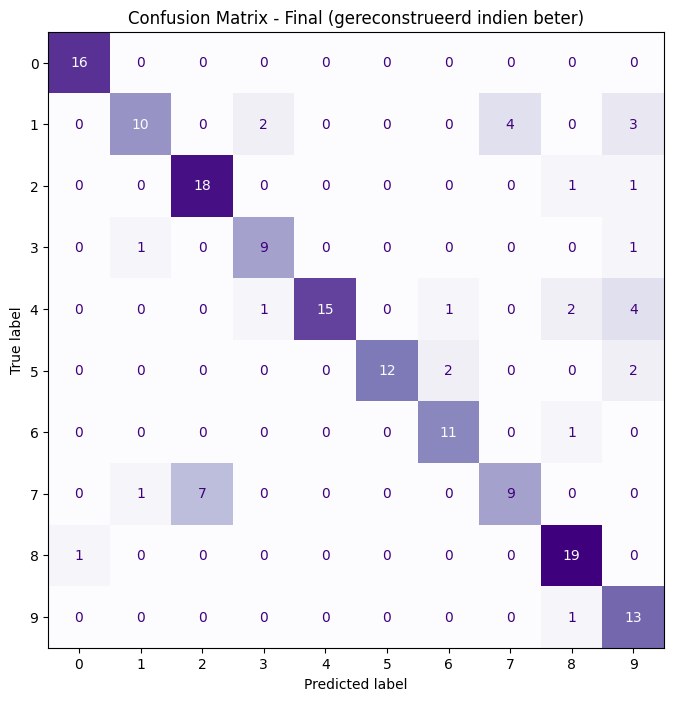


Aantal verbeterd (fout → goed): 9
Aantal verslechterd (goed → fout): 5


In [ ]:
if X_test_fixed_wit.max() > 1:
    X_test_fixed_wit = X_test_fixed_wit / 255.0

y_pred_probs_orig = model.predict(X_test_corrupt_wit)
y_pred_orig = np.argmax(y_pred_probs_orig, axis=1)
conf_orig = np.max(y_pred_probs_orig, axis=1)


y_pred_probs_fixed = model.predict(X_test_fixed_wit)
y_pred_fixed = np.argmax(y_pred_probs_fixed, axis=1)
conf_fixed = np.max(y_pred_probs_fixed, axis=1)

y_pred_final = y_pred_orig.copy()
use_recon_mask = conf_fixed > conf_orig
y_pred_final[use_recon_mask] = y_pred_fixed[use_recon_mask]


print("\nResultaten na reconstructie (wit) met confidence check:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_final, digits=4))

# Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Purples', colorbar=False)
plt.title("Confusion Matrix - Final (gereconstrueerd indien beter)")
plt.show()

reconstructed_indices = np.where(conf_fixed > conf_orig)[0]

original_preds = y_pred_orig[reconstructed_indices]
reconstructed_preds = y_pred_fixed[reconstructed_indices]
true_labels = y_test[reconstructed_indices]

verbeterd = np.sum((original_preds != true_labels) & (reconstructed_preds == true_labels))
verslechterd = np.sum((original_preds == true_labels) & (reconstructed_preds != true_labels))

print(f"\nAantal verbeterd (fout → goed): {verbeterd}")
print(f"Aantal verslechterd (goed → fout): {verslechterd}")


Accuracy per cijfer (voor en na reconstructie):
       Accuracy (Origineel)  Accuracy (Na Reconstructie)
label                                                   
0                    1.0000                       1.0000
1                    0.4737                       0.5263
2                    0.9000                       0.9000
3                    0.8182                       0.8182
4                    0.6522                       0.6522
5                    0.6875                       0.7500
6                    0.8333                       0.9167
7                    0.4706                       0.5294
8                    1.0000                       0.9500
9                    0.8571                       0.9286


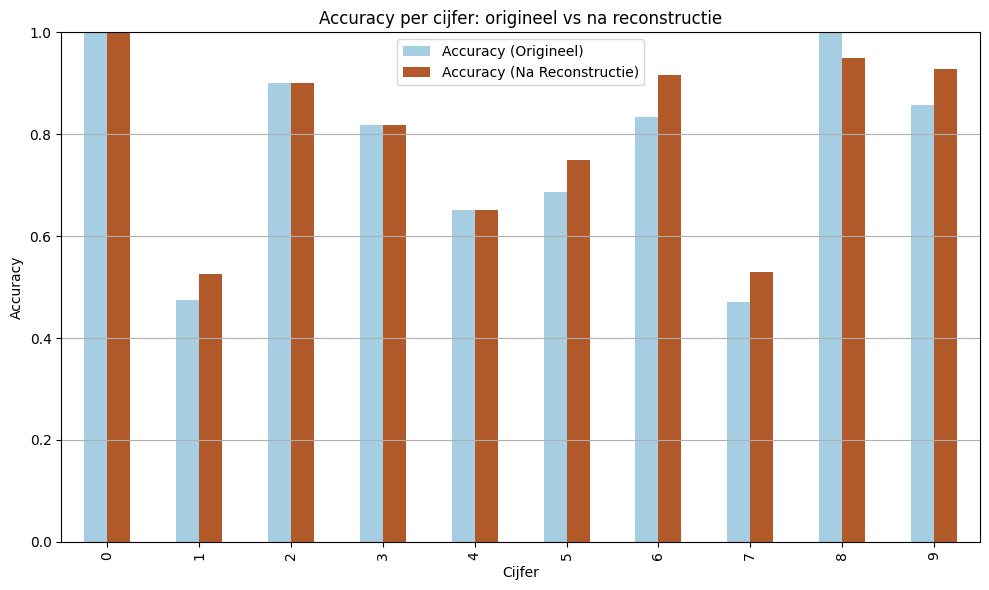


Gemiddelde cijfer-accuratesse vóór reconstructie: 0.7619
Gemiddelde cijfer-accuratesse ná reconstructie:  0.7857


In [27]:
import pandas as pd

# Per-klas accuracy vóór reconstructie
acc_per_class_orig = (y_pred_orig == y_test)
acc_orig_df = pd.DataFrame({'label': y_test, 'correct': acc_per_class_orig})
acc_per_digit_orig = acc_orig_df.groupby('label')['correct'].mean()

# Per-klas accuracy ná reconstructie (met confidence check)
acc_per_class_final = (y_pred_final == y_test)
acc_final_df = pd.DataFrame({'label': y_test, 'correct': acc_per_class_final})
acc_per_digit_final = acc_final_df.groupby('label')['correct'].mean()

# Combineer
acc_comparison = pd.DataFrame({
    'Accuracy (Origineel)': acc_per_digit_orig,
    'Accuracy (Na Reconstructie)': acc_per_digit_final
}).round(4)

print("\nAccuracy per cijfer (voor en na reconstructie):")
print(acc_comparison)
acc_comparison.plot(kind='bar', figsize=(10, 6), colormap='Paired')
plt.title("Accuracy per cijfer: origineel vs na reconstructie")
plt.xlabel("Cijfer")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Gemiddelde cijfer-accuratesse vóór reconstructie
cijfer_acc_orig = accuracy_score(y_test, y_pred_orig)

# Gemiddelde cijfer-accuratesse ná reconstructie (met confidence check)
cijfer_acc_final = accuracy_score(y_test, y_pred_final)

print(f"\nGemiddelde cijfer-accuratesse vóór reconstructie: {cijfer_acc_orig:.4f}")
print(f"Gemiddelde cijfer-accuratesse ná reconstructie:  {cijfer_acc_final:.4f}")


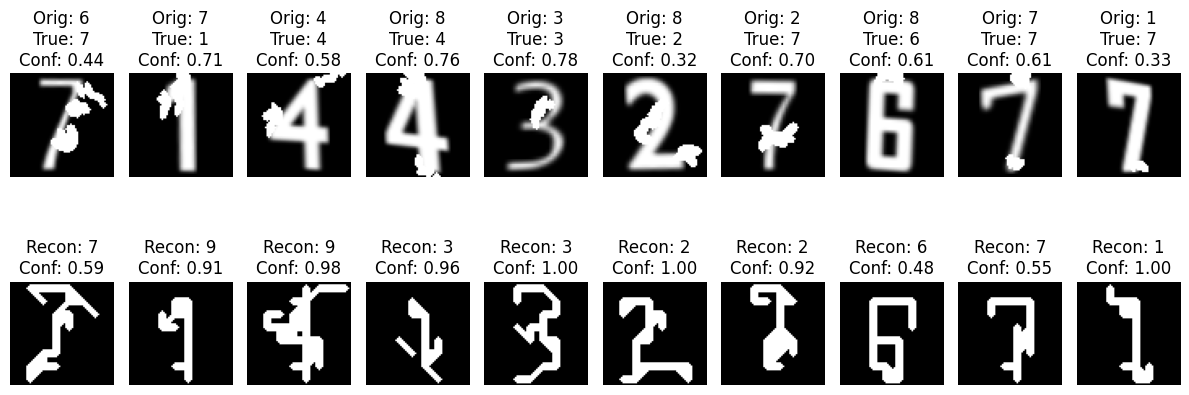

In [28]:
n = 10
np.random.seed(40)
indices = np.random.choice(lowconf_indices, size=n, replace=False)

plt.figure(figsize=(12, 5))
for i, original_idx in enumerate(indices):
    # Positie in gerepareerde set
    fixed_idx = original_idx

    # Origineel (voor reconstructie)
    plt.subplot(2, n, i + 1)
    orig_img = X_test_corrupt_wit[original_idx].squeeze()
    orig_conf = conf_wit[original_idx]
    orig_pred = y_pred_wit[original_idx]
    true_label = y_test[original_idx]
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Orig: {orig_pred}\nTrue: {true_label}\nConf: {orig_conf:.2f}")
    plt.axis('off')

    # Gereconstrueerd beeld dat op dezelfde plek zit in de gerepareerde set
    plt.subplot(2, n, i + 1 + n)
    recon_img = X_test_fixed_wit[fixed_idx].squeeze()
    recon_pred = y_pred_fixed[fixed_idx]
    recon_conf = np.max(y_pred_probs_fixed[fixed_idx])
    plt.imshow(recon_img, cmap='gray')
    plt.title(f"Recon: {recon_pred}\nConf: {recon_conf:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Combi

## INITIËLE CNN-VOORSPELLING OP CORRUPTE TESTSET 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy op corrupte testset (combi): 0.8452
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
           1     1.0000    0.8421    0.9143        19
           2     0.8000    1.0000    0.8889        20
           3     0.7500    0.8182    0.7826        11
           4     0.9412    0.6957    0.8000        23
           5     0.8750    0.8750    0.8750        16
           6     0.6923    0.7500    0.7200        12
           7     0.9167    0.6471    0.7586        17
           8     0.7727    0.8500    0.8095        20
           9     0.7368    1.0000    0.8485        14

    accuracy                         0.8452       168
   macro avg     0.8485    0.8478    0.8397       168
weighted avg     0.8605    0.8452    0.8438       168



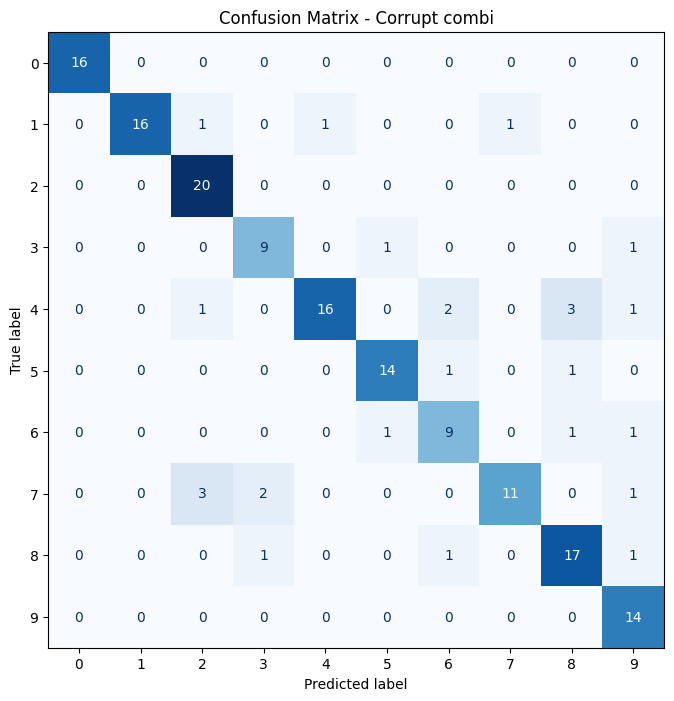

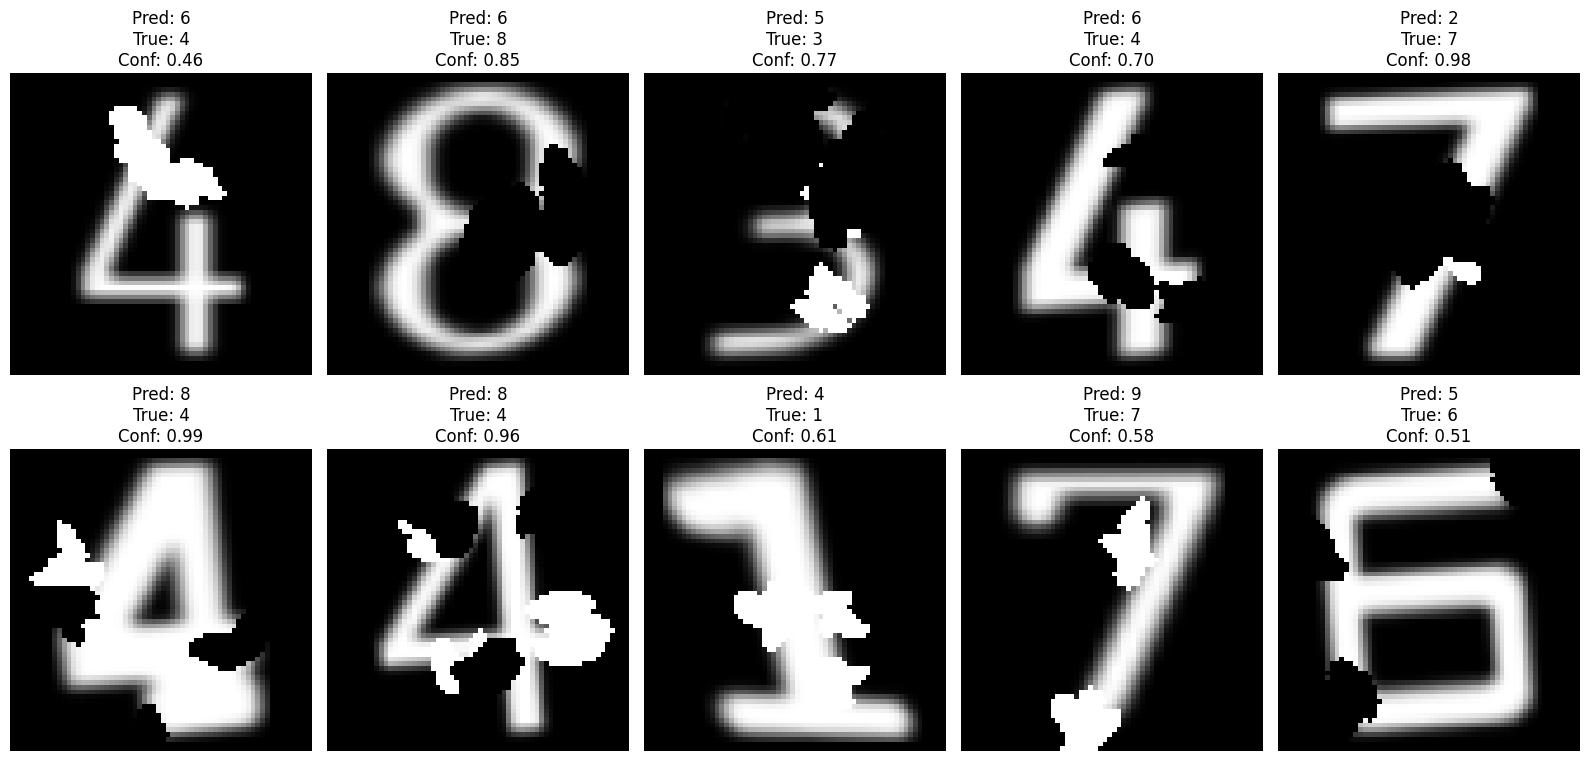

In [ ]:
y_pred_probs = model.predict(X_test_corrupt)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluatie
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy op corrupte testset (combi): {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Corrupt combi")
plt.show()

# Toon enkele foutieve voorbeelden
wrong_indices = np.where(y_pred != y_test)[0]
plt.figure(figsize=(16, 8))
for i, idx in enumerate(wrong_indices[:10]):
    img = X_test_corrupt[idx].squeeze()
    pred = y_pred[idx]
    true = y_test[idx]
    conf = np.max(y_pred_probs[idx])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred}\nTrue: {true}\nConf: {conf:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## CONFIDENCE-ANALYSE

In [ ]:
conf = np.max(y_pred_probs_wit, axis=1)
conf_thresh = 0.8

# Maskers
high_mask = conf_wit >= conf_thresh
low_mask= conf < conf_thresh

# Statistieken
n_total = len(y_test)
n_high = np.sum(high_mask_wit)
n_low = np.sum(low_mask)
correct_high = np.sum(y_pred[high_mask] == y_test[high_mask])
correct_low = np.sum(y_pred_wit[low_mask] == y_test[low_mask])

print(f"\nConfidence verdeling (drempel {conf_thresh}):")
print(f"  Hoog vertrouwen: {n_high}/{n_total} ({n_high/n_total:.2%})")
print(f"    → Goed: {correct_high}   Fout: {n_high - correct_high}")
print(f"  Laag vertrouwen: {n_low}/{n_total} ({n_low/n_total:.2%})")
print(f"    → Goed: {correct_low}   Fout: {n_low - correct_low}")



Confidence verdeling (drempel 0.8):
  Hoog vertrouwen: 126/168 (75.00%)
    → Goed: 111   Fout: 15
  Laag vertrouwen: 42/168 (25.00%)
    → Goed: 19   Fout: 23


## GNN-RECONSTRUCTIE VAN LAGE-CONFIDENCE BEELDEN

In [49]:
X_lowconf = X_test_corrupt[low_mask]
y_lowconf = y_test[low_mask]

In [ ]:
lowconf_dataset = PyGSkeletonDataset(images=X_lowconf.squeeze(), labels=y_lowconf, grid_size=8)

reconstructed_images = []
for data in lowconf_dataset:
    reconstructed_edge_index = reconstruct_edges(data, model_gnn, threshold=0.98)
    reconstructed_edge_index, _ = remove_self_loops(reconstructed_edge_index)
    reconstructed_edge_index = filter_directe_buren(reconstructed_edge_index)
    binary_img = edge_index_to_image(reconstructed_edge_index)
    reconstructed_images.append(binary_img)

reconstructed_images = np.expand_dims(np.array(reconstructed_images), axis=-1).astype(np.float32)


In [ ]:
X_test_fixed = X_test_corrupt.copy()

lowconf_indices = np.where(low_mask)[0]

assert len(lowconf_indices) == len(reconstructed_images), "Mismatch in reconstructie-aantallen"

for i, idx in enumerate(lowconf_indices):
    X_test_fixed[idx] = reconstructed_images[i]


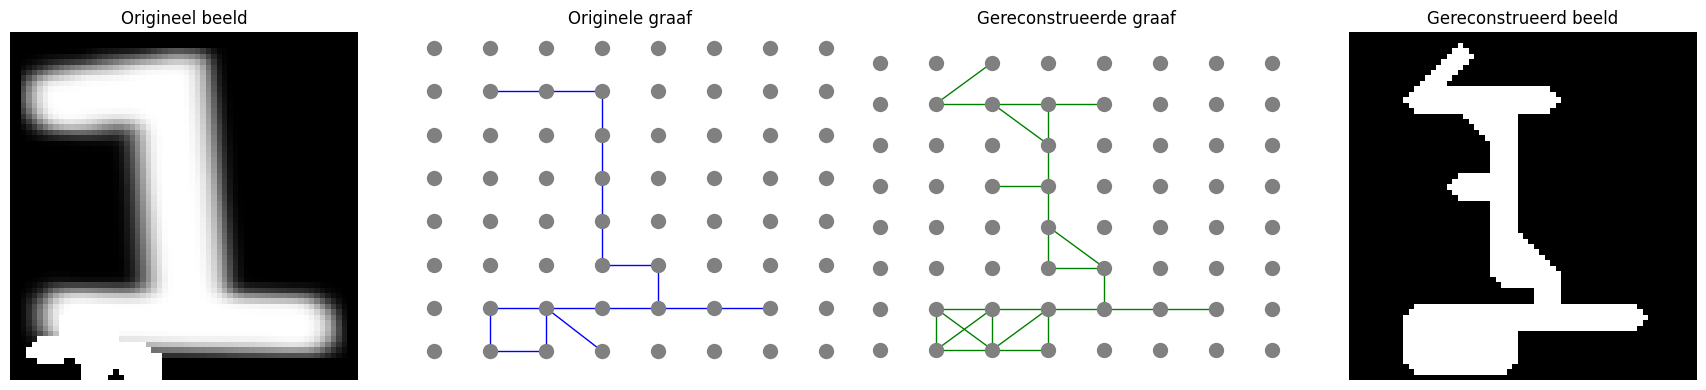

In [ ]:
sample_data = lowconf_dataset[0]original_img = X_lowconf[0].squeeze()

# Reconstrueer graaf
reconstructed_edge_index = reconstruct_edges(sample_data, model_gnn, threshold=0.96)
reconstructed_edge_index, _ = remove_self_loops(reconstructed_edge_index)
reconstructed_edge_index = filter_directe_buren(reconstructed_edge_index)
binary_img = edge_index_to_image(reconstructed_edge_index)

# Posities van 8x8 grid
positions = {i: (i % 8, 7 - i // 8) for i in range(64)}

# Functie om edge_index naar networkx-graf om te zetten
def edge_index_to_nx(edge_index):
    G = nx.Graph()
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    G.add_nodes_from(range(64))
    return G

# Originele en gereconstrueerde graaf
original_graph = edge_index_to_nx(sample_data.edge_index)
reconstructed_graph = edge_index_to_nx(reconstructed_edge_index)

# Visualisatie
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# 1. Origineel beeld
axes[0].imshow(original_img, cmap='gray')
axes[0].set_title("Origineel beeld")
axes[0].axis('off')

# 2. Originele graaf
nx.draw(original_graph, pos=positions, node_size=100, node_color='gray',
        edge_color='blue', with_labels=False, ax=axes[1])
axes[1].set_title("Originele graaf")

# 3. Gereconstrueerde graaf
nx.draw(reconstructed_graph, pos=positions, node_size=100, node_color='gray',
        edge_color='green', with_labels=False, ax=axes[2])
axes[2].set_title("Gereconstrueerde graaf")

# 4. Beeld uit gereconstrueerde graaflow_conf_mask
axes[3].imshow(binary_img, cmap='gray')
axes[3].set_title("Gereconstrueerd beeld")
axes[3].axis('off')

plt.tight_layout()
plt.show()



Resultaten na reconstructie (combi) met confidence check:
Accuracy: 0.8393
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
           1     1.0000    0.9474    0.9730        19
           2     0.8000    1.0000    0.8889        20
           3     0.6429    0.8182    0.7200        11
           4     1.0000    0.7391    0.8500        23
           5     0.8462    0.6875    0.7586        16
           6     0.7500    0.7500    0.7500        12
           7     1.0000    0.5882    0.7407        17
           8     0.8095    0.8500    0.8293        20
           9     0.6364    1.0000    0.7778        14

    accuracy                         0.8393       168
   macro avg     0.8485    0.8380    0.8288       168
weighted avg     0.8673    0.8393    0.8389       168


Resultaten na reconstructie (combi) met confidence check:
Accuracy: 0.8393
Classification Report:
              precision    recall  f1-score

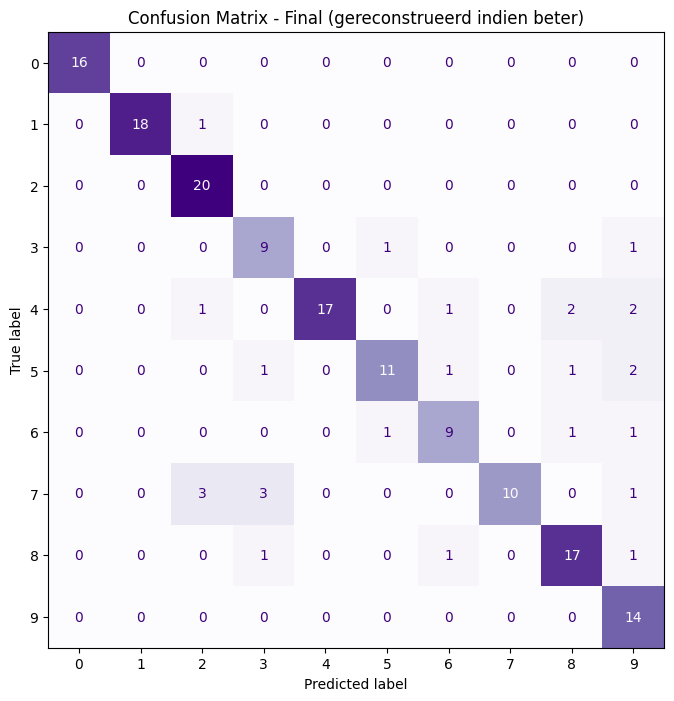


Aantal verbeterd (fout → goed): 4
Aantal verslechterd (goed → fout): 5


In [ ]:
print("\nResultaten na reconstructie (combi) met confidence check:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_final, digits=4))
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\nResultaten na reconstructie (combi) met confidence check:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_final, digits=4))

# Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Purples', colorbar=False)
plt.title("Confusion Matrix - Final (gereconstrueerd indien beter)")
plt.show()

reconstructed_indices = np.where(conf_fixed > conf_orig)[0]

original_preds = y_pred_orig[reconstructed_indices]
reconstructed_preds = y_pred_fixed[reconstructed_indices]
true_labels = y_test[reconstructed_indices]

verbeterd = np.sum((original_preds != true_labels) & (reconstructed_preds == true_labels))
verslechterd = np.sum((original_preds == true_labels) & (reconstructed_preds != true_labels))

print(f"\nAantal verbeterd (fout → goed): {verbeterd}")
print(f"Aantal verslechterd (goed → fout): {verslechterd}")



Accuracy per cijfer (voor en na reconstructie):
       Accuracy (Origineel)  Accuracy (Na Reconstructie)
label                                                   
0                    1.0000                       1.0000
1                    0.8421                       0.9474
2                    1.0000                       1.0000
3                    0.8182                       0.8182
4                    0.6957                       0.7391
5                    0.8750                       0.6875
6                    0.7500                       0.7500
7                    0.6471                       0.5882
8                    0.8500                       0.8500
9                    1.0000                       1.0000


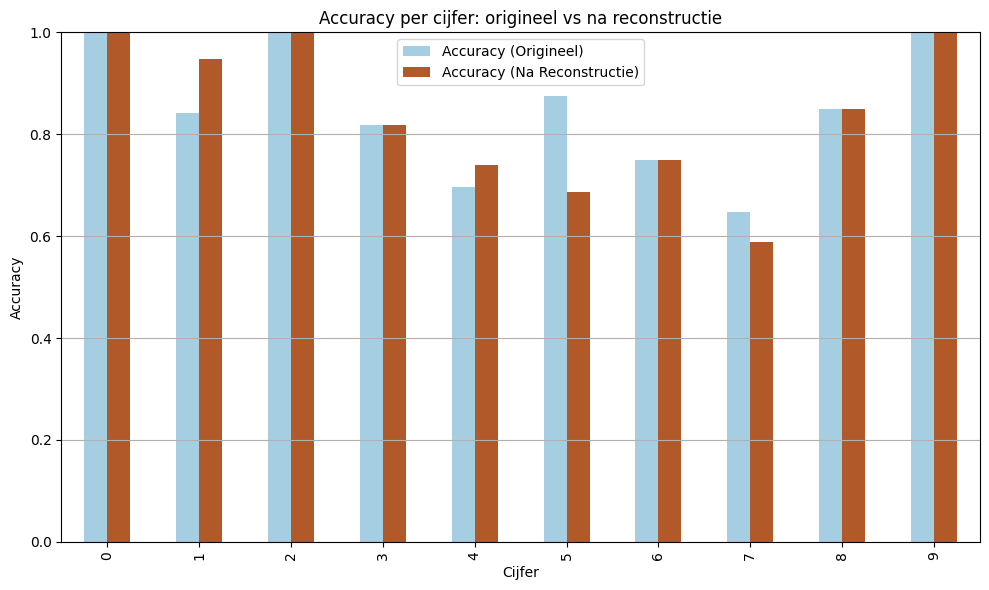


Gemiddelde cijfer-accuratesse vóór reconstructie: 0.8452
Gemiddelde cijfer-accuratesse ná reconstructie:  0.8393


In [ ]:
# Per-klas accuracy vóór reconstructie
acc_per_class_orig = (y_pred_orig == y_test)
acc_orig_df = pd.DataFrame({'label': y_test, 'correct': acc_per_class_orig})
acc_per_digit_orig = acc_orig_df.groupby('label')['correct'].mean()

# Per-klas accuracy ná reconstructie (met confidence check)
acc_per_class_final = (y_pred_final == y_test)
acc_final_df = pd.DataFrame({'label': y_test, 'correct': acc_per_class_final})
acc_per_digit_final = acc_final_df.groupby('label')['correct'].mean()

# Combineer
acc_comparison = pd.DataFrame({
    'Accuracy (Origineel)': acc_per_digit_orig,
    'Accuracy (Na Reconstructie)': acc_per_digit_final
}).round(4)

print("\nAccuracy per cijfer (voor en na reconstructie):")
print(acc_comparison)
acc_comparison.plot(kind='bar', figsize=(10, 6), colormap='Paired')
plt.title("Accuracy per cijfer: origineel vs na reconstructie")
plt.xlabel("Cijfer")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Gemiddelde cijfer-accuratesse vóór reconstructie
cijfer_acc_orig = accuracy_score(y_test, y_pred_orig)

# Gemiddelde cijfer-accuratesse ná reconstructie (met confidence check)
cijfer_acc_final = accuracy_score(y_test, y_pred_final)

print(f"\nGemiddelde cijfer-accuratesse vóór reconstructie: {cijfer_acc_orig:.4f}")
print(f"Gemiddelde cijfer-accuratesse ná reconstructie:  {cijfer_acc_final:.4f}")


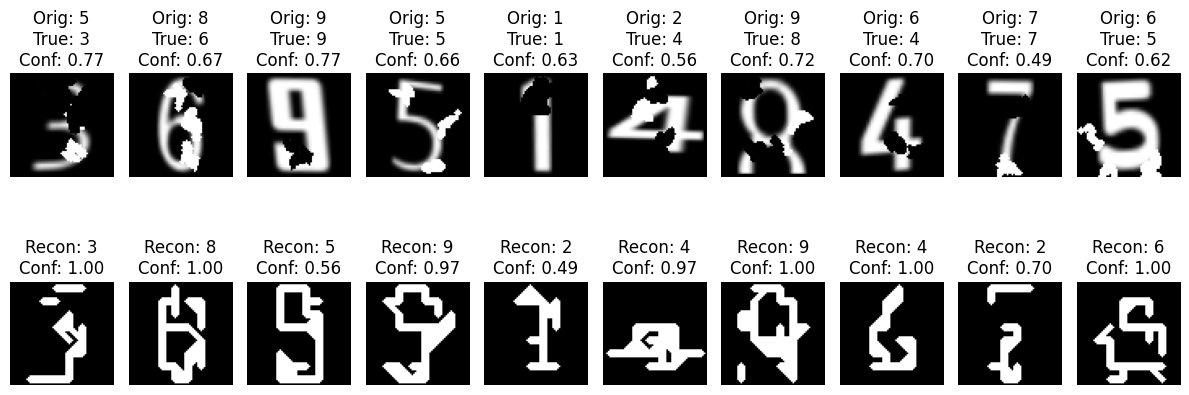

In [ ]:
n = 10
np.random.seed(40)
indices = np.random.choice(lowconf_indices, size=n, replace=False)

plt.figure(figsize=(12, 5))
for i, original_idx in enumerate(indices):
    # Positie in gerepareerde set
    fixed_idx = original_idx

    # Origineel (voor reconstructie)
    plt.subplot(2, n, i + 1)
    orig_img = X_test_corrupt[original_idx].squeeze()
    orig_conf = conf[original_idx]
    orig_pred = y_pred[original_idx]
    true_label = y_test[original_idx]
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Orig: {orig_pred}\nTrue: {true_label}\nConf: {orig_conf:.2f}")
    plt.axis('off')

    # Gereconstrueerd beeld dat op dezelfde plek zit in de gerepareerde set
    plt.subplot(2, n, i + 1 + n)
    recon_img = X_test_fixed[fixed_idx].squeeze()
    recon_pred = y_pred_fixed[fixed_idx]
    recon_conf = np.max(y_pred_probs_fixed[fixed_idx])
    plt.imshow(recon_img, cmap='gray')
    plt.title(f"Recon: {recon_pred}\nConf: {recon_conf:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()
